Here we will investigate the country differences within the microbial communities.  Here we will use Ward hierarchical clustering to identify very obvious patterns.  This method trys to identify maximum variance partitions, and runs linear regression investigate if the balances between these highly variable subcommunities can be explained using the variables that have measured.

Make sure that the appropriate files are downloaded.  They can be obtained from the ftp link using the following commands

```bash
wget ftp://ftp.microbio.me/AmericanGut/manuscript-package/1250/deblur_125nt_no_blooms_rare.biom

wget ftp://ftp.microbio.me/AmericanGut/manuscript-package/1250/ag_map_with_alpha.txt
```

Now we will run the qiime2 analyses to generate the balances and run the linear regression.  Remember, ANOVA is a type of linear regression, so we can test for differientially abundant balances using this technique.

To begin, let's boot up the gneiss command line interface using qiime2. We'll want to first specify the input files and the regression formula consisting of all of the variables that we would like to test for.

```
otu_table=deblur_125nt_no_blooms_rare.biom
metadata=coded_regression_map_5k.txt
formula="C(country)+C(ibd)+C(bowel_movement_quality)+C(ibs)+C(antibiotic_history)+C(race)+ln_age*C(sex)+types_of_plants"

```

```
qiime tools import \
    --input-path $otu_table \
    --output-path $otu_table --type FeatureTable[Frequency]
```

```
qiime feature-table filter-samples \
                   --i-table "$otu_table".qza \
                   --m-metadata-file $metadata \
                   --o-filtered-table "$otu_table".filt.qza
```

```
qiime feature-table filter-features \
                   --i-table "$otu_table".filt.qza \
                    --o-filtered-table "$otu_table".filt.qza \
                    --p-min-frequency 10
```

```    
qiime composition add-pseudocount \
    --i-table "$otu_table".filt.qza \
    --p-pseudocount 1 \
    --o-composition-table "$otu_table".composition
```    

```
qiime gneiss correlation-clustering \
    --i-table "$otu_table".composition.qza \
    --o-clustering "$otu_table".tree.nwk.qza
```

```
qiime gneiss ilr-transform \
    --i-table "$otu_table".composition.qza \
    --i-tree "$otu_table".tree.nwk.qza \
    --o-balances "$otu_table".balances
```

```
qiime gneiss ols-regression \
    --p-formula $formula \
    --i-table "$otu_table".balances.qza \
    --i-tree "$otu_table".balances.tree.nwk.qza \
    --m-metadata-file ag_map_with_alpha.txt \
    --o-visualization ag_regression.filt.2.summary --verbose
```

Once we have the summaries generated, we can plug them directly into https://view.qiime2.org/
You may note that one balance that stands out is `y2`.  We'll revisit that balance in a bit.

From now on, we'll analyze the result using the Gneiss Python API.

In [1]:
from gneiss.composition import ilr_transform
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import rc

from biom import load_table
from skbio import TreeNode
import qiime2
import seaborn as sns
%matplotlib inline

We'll load all of the files, and parse out the taxonomies from the biom table.

In [2]:
mapping = pd.read_table('ag_map_with_alpha.txt', index_col=0)

table = load_table('deblur_125nt_no_blooms.biom')
balances = qiime2.Artifact.load(
    'deblur_125nt_no_blooms_rare.biom.balances.qza').view(pd.DataFrame)
tree = qiime2.Artifact.load(
    'deblur_125nt_no_blooms_rare.biom.tree.nwk.qza').view(TreeNode)

obs_ids = table.ids(axis='observation')
taxa = [table.metadata(id=i, axis='observation')['taxonomy'] for i in obs_ids]
taxa = pd.DataFrame(taxa, index=obs_ids, 
                    columns=['kingdom', 'phylum', 'class', 'order', 
                             'family', 'genus', 'species'])

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0,66) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


We'll pull out all of the pvalues from the summary file -- just in case we want to investigate the pvalues from the linear regression in the future.

In [3]:
viz = qiime2.Visualization.load('ag_regression.filt.2.summary.qzv')
viz.export_data('regression_summary_dir')

pvals = pd.read_csv('regression_summary_dir/pvalues.csv', index_col=0)

We'll deposit all of the balance summaries into a csv file, so that we can clearly identify which microbes
are in the numerator and denominator of this balance referred to as `y2`.

In [4]:
from gneiss.util import NUMERATOR, DENOMINATOR

balance_summary = pd.concat((taxa.loc[tree.find('y2').children[NUMERATOR].subset()],
                             taxa.loc[tree.find('y2').children[DENOMINATOR].subset()]))
def position(x):
    if (x in tree.find('y2').children[NUMERATOR].subset()):
        return 'denominator'
    else:
        return 'numerator'

balance_summary['balance'] = 'y2'
balance_summary['position'] = list(map(position, balance_summary.index))
balance_summary.to_csv('country_balance_summary.csv')

For the purposes of plotting the balances, we'll want to exclude countries that aren't the US, UK or Canada.
We'll also want to refer to the USA as the United States.

In [5]:
def rename_country(x):
    if x == 'USA':
        return 'United States'
    elif x in ['United Kingdom', 'Canada']:
        return x
    else:
        return np.nan

mapping['country'] = mapping['country'].apply(rename_country)
mapping = mapping.dropna(subset=['country'])

Now we will create the boxplots of the balances, specifically comparing the USA, UK and Canada populations.

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


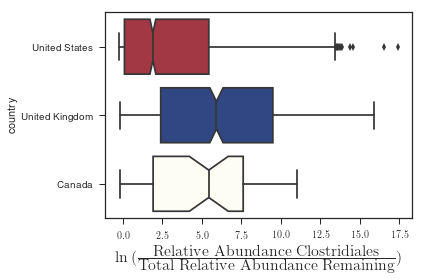

In [6]:
from gneiss.plot import balance_boxplot, balance_barplots
from matplotlib import rc

sns.set_style('white')
sns.set_style('ticks')
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

fig, ax = plt.subplots()
data = pd.merge(mapping, balances, left_index=True, right_index=True)

# Flip the balance (i.e. swap the numerator and denominator).
data['y2_y'] = -1*data['y2']

sns.boxplot(x='country', y='y2_y', data=data, notch=True, vert=False,  ax=ax,
            palette={'United States': '#b22637',
                     'United Kingdom': '#224191',
                     'Canada': '#fffef3'
                    }
)
# #16295b blue United Kingdom
# #224191 blue United Kingdom
# #b22637 red  United States
ax.set_yticklabels(['United States', 'United Kingdom', 'Canada'])
ax.set_xlabel(r'$\ln \big(\frac{\textrm{Relative Abundance Clostridiales}}{\textrm{Total Relative Abundance Remaining} }\big)$', fontsize=16)
plt.tight_layout()

plt.savefig('country.pdf')

As noted, there are some clear cut patterns with respect to this `y2` balance.